In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/sms-spam-collection-dataset/spam.csv
/kaggle/input/masksforwordclouds/twitter_mask2.png
/kaggle/input/masksforwordclouds/twitter_mask4.jpg
/kaggle/input/masksforwordclouds/twitter_mask3.jpg
/kaggle/input/masksforwordclouds/book-logo-1.jpg
/kaggle/input/masksforwordclouds/twitter_mask.png
/kaggle/input/masksforwordclouds/wordcloud-man.png
/kaggle/input/masksforwordclouds/twitter_mask3.png


In [2]:
!pip install plotly

In [3]:
import re
import string
import numpy as np
import random
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import Counter

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)


2024-04-04 18:17:40.380664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 18:17:40.380804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 18:17:40.511780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [5]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding="Latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df=df.dropna(axis=1)
df.columns=["target","message"]
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df["message_len"]=df["message"].apply(lambda x:len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [8]:
max(df["message_len"])

171

In [9]:
df.shape

(5572, 3)

In [10]:
df['target'].value_counts() 

target
ham     4825
spam     747
Name: count, dtype: int64

# **EDA**

In [11]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color="green"
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color="orange"
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

# **Data Preprocessing**

In [13]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
df["message"]=df["message"].apply(clean_text)
df.head()

,target,message,message_len
0,ham,go until jurong point crazy available only in ...,20
1,ham,ok lar joking wif u oni,6
2,spam,free entry in a wkly comp to win fa cup final...,28
3,ham,u dun say so early hor u c already then say,11
4,ham,nah i dont think he goes to usf he lives aroun...,13


**Stopwords**

In [15]:
!pip install nltk

In [16]:
 >>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords
stop_words=stopwords.words("english")
more_stopwords=['u','im','c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text=' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [18]:
df["message"]=df["message"].apply(remove_stopwords)
df.head()

,target,message,message_len
0,ham,go jurong point crazy available bugis n great ...,20
1,ham,ok lar joking wif oni,6
2,spam,free entry wkly comp win fa cup final tkts m...,28
3,ham,dun say early hor already say,11
4,ham,nah dont think goes usf lives around though,13


**Stemming**

In [19]:
import nltk
stemmer=nltk.SnowballStemmer("english")

def Stemming_(text):
    text=' '.join(stemmer.stem(word) for word in text.split(" "))
    return text

In [20]:
df["message"]=df["message"].apply(Stemming_)
df.head()

,target,message,message_len
0,ham,go jurong point crazi avail bugi n great world...,20
1,ham,ok lar joke wif oni,6
2,spam,free entri wkli comp win fa cup final tkts m...,28
3,ham,dun say earli hor alreadi say,11
4,ham,nah dont think goe usf live around though,13


**All preprocessing technique At Once**

In [21]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [22]:
df['message'] = df['message'].apply(preprocess_data)
df.head()

,target,message,message_len
0,ham,go jurong point crazi avail bugi n great world...,20
1,ham,ok lar joke wif oni,6
2,spam,free entri wkli comp win fa cup final tkts m...,28
3,ham,dun say ear hor alreadi say,11
4,ham,nah dont think goe usf live around though,13


In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['target'])

df['target_encoded'] = label_encoder.transform(df['target'])
df.head()

,target,message,message_len,target_encoded
0,ham,go jurong point crazi avail bugi n great world...,20,0
1,ham,ok lar joke wif oni,6,0
2,spam,free entri wkli comp win fa cup final tkts m...,28,1
3,ham,dun say ear hor alreadi say,11,0
4,ham,nah dont think goe usf live around though,13,0


# **Data Visualization**

In [24]:
!pip install wordCloud

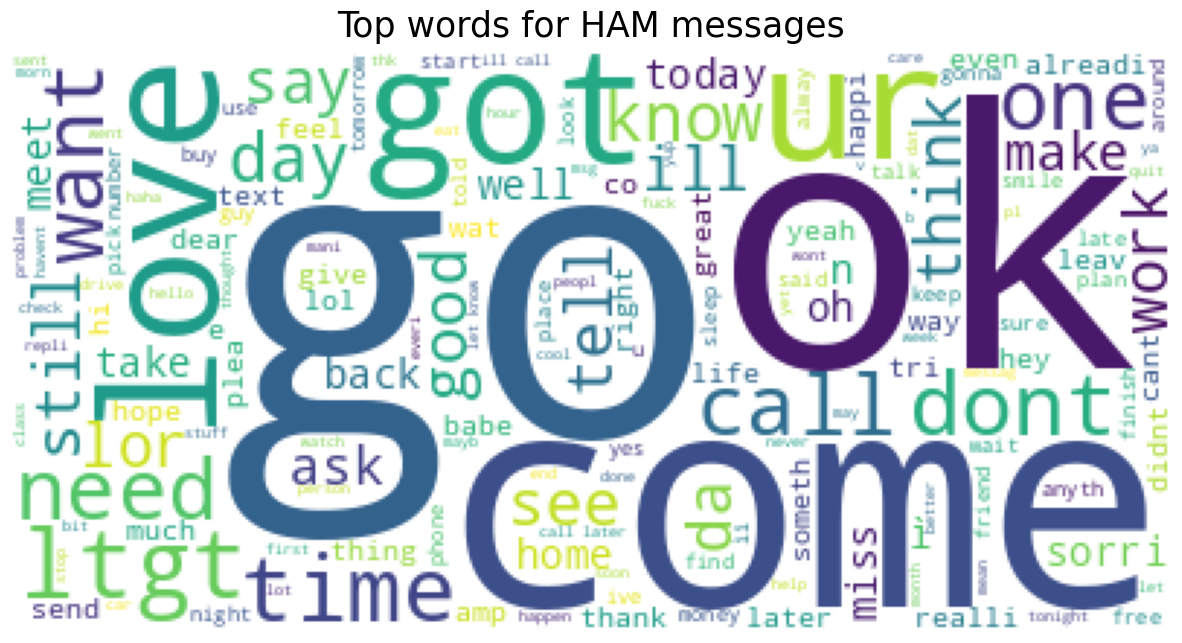

In [25]:
from PIL import Image
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'message']))
plt.figure(figsize=(15,9))
plt.title('Top words for HAM messages', 
          fontdict={'size': 25,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

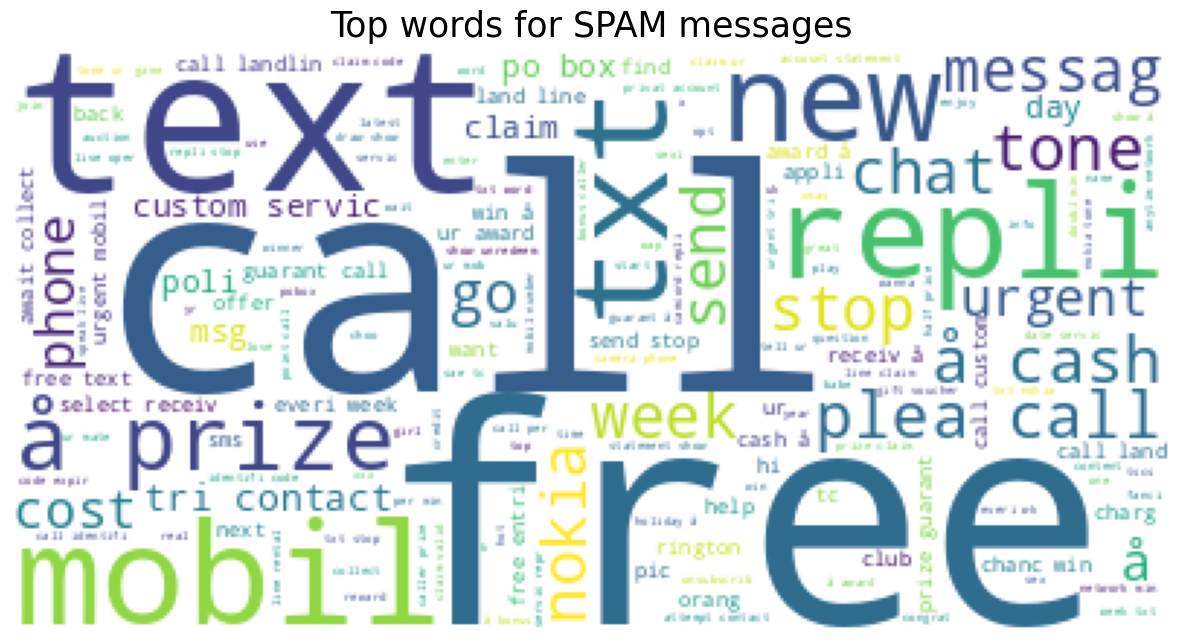

In [26]:
from PIL import Image
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'message']))
plt.figure(figsize=(15,9))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 25,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# **Train-Test Split**

In [27]:
x = df['message']
y = df['target']

print(len(x), len(y))

5572 5572


In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


**Vectorization as Document Frequency**

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [30]:
# Use the trained to create a document-term matrix from train and test sets
x_train_docfreq = vect.transform(x_train)
x_test_docfreq = vect.transform(x_test)

**Term Frequency Inverse Document Frequency**

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_docfreq)
x_train_tfidf = tfidf_transformer.transform(x_train_docfreq)

x_train_tfidf

<4179x5684 sparse matrix of type '<class 'numpy.float64'>'
	with 32201 stored elements in Compressed Sparse Row format>

**N-GRAM (Bi-gram)**

In [32]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
# max_df/min_df : number will be interpreted as a frequency rather than a numerical limit
vect_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

# **Word Embeddings: GloVe**

**Tokenize**

In [33]:
texts = df['message']
target = df['target']

In [34]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer


# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6726

**Pad_sequences**

In [35]:
>>> import nltk
>>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences

def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

**Glove(Global Vectors for Word Representation) Unsupervised Algo**

In [37]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [38]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# **Models**

In [39]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

# **Naive Bayes**

In [40]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_docfreq, y_train)

MultinomialNB()

In [41]:
y_pred_class = nb.predict(x_test_docfreq)
y_pred_prob = nb.predict_proba(x_test_docfreq)[:, 1]

In [42]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9784637473079684


In [43]:
metrics.roc_auc_score(y_test, y_pred_prob)

0.9742967654258609

# **Naive Bayes using Pipeline**

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])
pipe.fit(x_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [45]:
y_pred_class = pipe.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9597989949748744


In [46]:
conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

# **XGBoost**

In [47]:
!pip install xgboost

In [48]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=10,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [49]:
x = df['message']
y1=df["target_encoded"]


print(len(x), len(y1))

5572 5572


In [50]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y1, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [51]:
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

In [52]:
print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

Train: 0.9861210815984686
Test: 0.9669777458722182


In [53]:
conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

# **LSTM**

In [54]:
target1=df["target_encoded"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target1, 
    test_size=0.2
)
print(X_train.shape,y_train.shape)

(4457, 80) (4457,)


In [56]:
y_train

4814    0
4966    1
2991    0
3380    1
4759    0
       ..
2930    0
2588    0
4156    0
3687    0
4945    0
Name: target_encoded, Length: 4457, dtype: int64

In [57]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.initializers import RandomNormal
import tensorflow as tf

In [58]:
def glove_lstm(embedding_matrix, length_long_sentence):
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # Pass embedding_matrix as initializer

#         embeddings_initializer=RandomNormal(mean=0.0, stddev=0.05),  # another method for intitalising weights
        input_shape=(length_long_sentence,)  # Use input_shape instead of input_length
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences=True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [59]:
model = glove_lstm(embedding_matrix,length_long_sentence)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 80, 100)        │       672,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 160)        │       115,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 160)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         6,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 808,521 (3.08 MB)

 Trainable params: 808,201 (3.08 MB)

 Non-trainable params: 320 (1.25 KB)

In [60]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

model = glove_lstm(embedding_matrix,length_long_sentence)

checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 15,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8230 - loss: 0.4431
Epoch 1: val_loss improved from inf to 0.33631, saving model to model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.8234 - loss: 0.4423 - val_accuracy: 0.9453 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9419 - loss: 0.1611
Epoch 2: val_loss improved from 0.33631 to 0.12473, saving model to model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - accuracy: 0.9419 - loss: 0.1612 - val_accuracy: 0.9578 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9528 - loss: 0.1352
Epoch 3: val_loss did not improve from 0.12473
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.9528 - loss: 0.1351 - val_accuracy: 0.9596 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9725 - loss: 0.0884
Epoch 4: val_

In [61]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

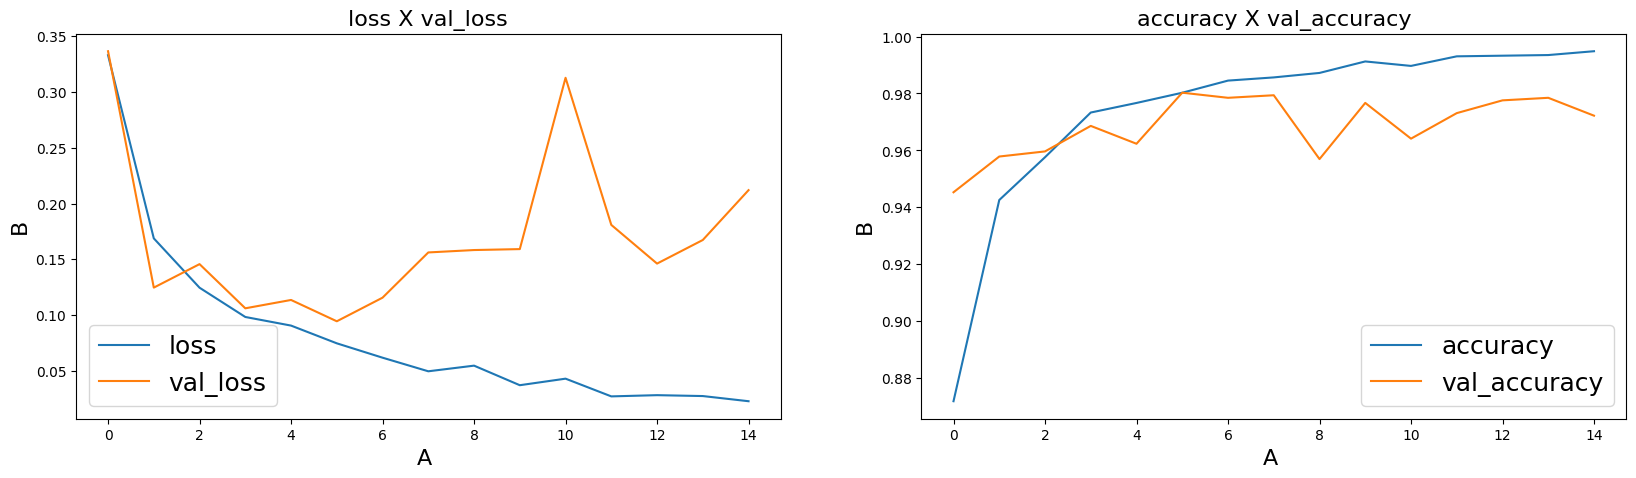

In [62]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [63]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


# **BERT**

In [64]:
# install transformers
!pip install transformers

In [65]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [66]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [67]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [68]:
texts = df['message']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



1. The CustomTFLayer acts as a bridge between Keras' symbolic tensors and TensorFlow functions.
2.  It encapsulates the call to bert_model within a layer that accepts and returns KerasTensors, ensuring compatibility within the model structure.

In [69]:
class CustomTFLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_masks = inputs
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_masks)
        return output

In [70]:
def create_model(model):
    input_ids = tf.keras.Input(shape=(60,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,), dtype='int32')
    
#     output = bert_model([input_ids,attention_masks]) #Incompatible error
    output = CustomTFLayer(bert_model)([input_ids, attention_masks])
    

    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [71]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [72]:
model = create_model(bert_model)
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_tf_layer     │ [(None, 60, 768), │          0 │ input_layer_2[0]… │
│ (CustomTFLayer)     │ (None, 768)]      │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │     24,608 │ custom_tf_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,641 (96.25 KB)

 Trainable params: 24,641 (96.25 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=10,
    batch_size=32
)

Epoch 1/10
  1/140 ━━━━━━━━━━━━━━━━━━━━ 45:09 19s/step - accuracy: 0.5000 - loss: 0.7119

I0000 00:00:1712255240.632004     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712255240.669863     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8462 - loss: 0.3713

W0000 00:00:1712255262.476849     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712255268.306215     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 53s 244ms/step - accuracy: 0.8463 - loss: 0.3710 - val_accuracy: 0.9049 - val_loss: 0.2445
Epoch 2/10


W0000 00:00:1712255274.625047     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.8982 - loss: 0.2586 - val_accuracy: 0.9049 - val_loss: 0.2135
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9107 - loss: 0.2366 - val_accuracy: 0.9399 - val_loss: 0.1816
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.9266 - loss: 0.2092 - val_accuracy: 0.9462 - val_loss: 0.1781
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.9355 - loss: 0.1952 - val_accuracy: 0.9471 - val_loss: 0.1707
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9360 - loss: 0.1850 - val_accuracy: 0.9408 - val_loss: 0.1576
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.9426 - loss: 0.1723 - val_accuracy: 0.9444 - val_loss: 0.1631
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9355 - loss: 0.1794 - val_accuracy: 0.9220 - val_loss: 0.2058
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9292 - loss: 0.1925 - val

In [74]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)


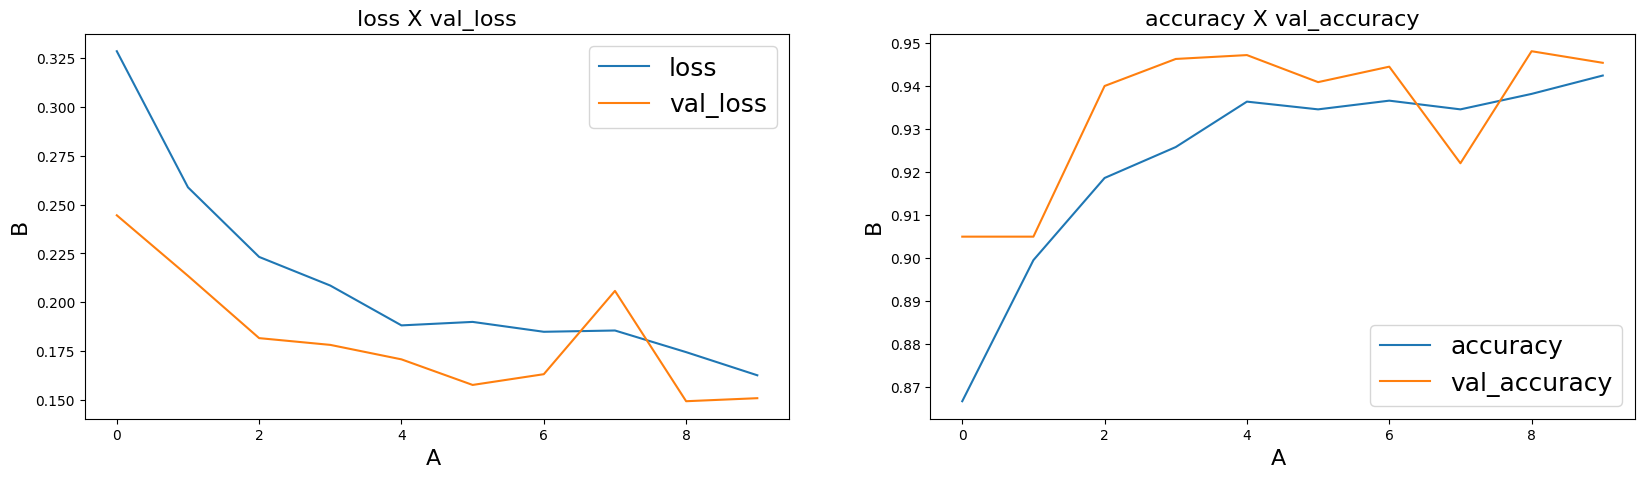

In [75]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])